In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.signal import butter, filtfilt, stft
import pywt

from collections import defaultdict


destination = 'collections_20250422_frequency'

# 設定帶通濾波器參數
lowcut = 60_000      # 60 kHz
highcut = 400_000    # 400 kHz
fs = 1_000_000       # 1 MHz

def bandpass_filter(data, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff, order=4):
    """
    Low-pass filter for 1D signal.
    :param data: Input signal (1D array)
    :param cutoff: Cutoff frequency (Hz)
    :param order: Filter order
    :return: Filtered signal
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def wavelet_denoise(data, wavelet='db4', threshold_method='soft'):
    maxlev = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet).dec_len)
    # maxlev = 8
    coeffs = pywt.wavedec(data, wavelet, level=maxlev)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs[1:] = [pywt.threshold(c, value=uthresh, mode=threshold_method) for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def plot_spectrum_default(label_list, freq_list, spec_list, enabled_db, enabled_functions, figsize=(7, 5)):
    label_spec_map = defaultdict(list)
    label_freq_map = {}

    for label, freq, spec in zip(label_list, freq_list, spec_list):
        label_spec_map[label].append(spec)
        label_freq_map[label] = freq  # 頻率軸對於同一 label 都一樣

    # 計算統計量
    stat_spec_map = {}
    for label, specs in label_spec_map.items():
        arr = np.vstack(specs)
        stat_spec_map[label] = {
            # 'mean': np.mean(arr, axis=0),
            'min': np.min(arr, axis=0),
            'max': np.max(arr, axis=0),
            'median': np.median(arr, axis=0),
            'q1': np.percentile(arr, 25, axis=0),
            'q3': np.percentile(arr, 75, axis=0),
        }

    # 使用subplot把各統計頻譜分開繪製
    n_labels = len(stat_spec_map)
    n_cols = 2
    n_rows = (n_labels + n_cols - 1) // n_cols
    col_size, row_size = figsize

    plt.figure(figsize=(col_size * n_cols, row_size * n_rows))
    for i, (label, stats) in enumerate(stat_spec_map.items()):
        freq = label_freq_map[label] / 1000  # kHz
        plt.subplot(n_rows, n_cols, i + 1)
        # plt.plot(freq, stats['mean'], label='Mean')
        plt.plot(freq, stats['max'], label='Max')
        plt.plot(freq, stats['q3'], label='Q3')
        plt.plot(freq, stats['median'], label='Median')
        plt.plot(freq, stats['q1'], label='Q1')
        plt.plot(freq, stats['min'], label='Min')
        plt.xlabel('Frequency (kHz)')
        plt.ylabel(f'Energy{enabled_db}')
        plt.title(f'Label: {label}{enabled_functions}')
        plt.legend(fontsize='small')
        plt.tight_layout()
    plt.show()

def plot_spectrum(label_list, freq_list, spec_list, enabled_db, enabled_functions, figsize=(10, 6), presentage = None):

    label_spec_map = defaultdict(list)
    label_freq_map = {}

    for label, freq, spec in zip(label_list, freq_list, spec_list):
        label_spec_map[label].append(spec)
        label_freq_map[label] = freq  # 頻率軸對於同一 label 都一樣

    # 計算統計量
    stat_spec_map = {}
    for label, specs in label_spec_map.items():
        arr = np.vstack(specs)
        stat_spec_map[label] = {
            'data': np.mean(arr, axis=0) if presentage is None
            else np.min(arr, axis=0) if presentage <= 0
            else np.max(arr, axis=0) if presentage >= 100
            else np.percentile(arr, presentage, axis=0),
        }

    plt.figure(figsize=tuple(figsize))
    for label, stats in stat_spec_map.items():
        freq = label_freq_map[label] / 1000  # kHz
        # 可根據需求選擇要畫哪些統計量
        plt.plot(freq, stats['data'], label=f'{label}')
        
    plt.xlabel('Frequency (kHz)')
    plt.ylabel(f'Energy{enabled_db}')
    
    title = 'mean' if presentage is None \
        else 'min' if presentage <= 0 \
        else 'max' if presentage >= 100 \
        else f'{presentage}%'
    
    plt.title(f'Spectrum [{title}]{enabled_functions}')
    
    plt.grid()
    plt.legend(fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

def process_data(
    file_path,
    nfft = None,
    enable_db = False,
    enable_wavelet_denoise = False,
    enable_bandpass_filter = False,
    label_transformer = lambda label: label,
    label_skipper = lambda label: False
):
    destination_file_list = []
    # source_file_list = []
    signal_list = []
    label_list = []
    spec_list = []
    freq_list = []
    
    enabled_functions = []
    
    if enable_bandpass_filter:
        enabled_functions.append(f'Filtered ({lowcut / 1000} - {highcut / 1000} kHz)')
        
    if enable_wavelet_denoise:
        enabled_functions.append('Denoised')
        
        
    
    for root, dirs, files in os.walk(file_path):

        label = root.split('\\')[-1].split('captured_data_')[-1].split('_collection')[0]
        label = label.split('_cycle')[0].split('_directly')[0]
        
        label = label_transformer(label)
        
        if label_skipper(label):
            continue
        
        for file in files:
            if file.endswith('.csv'):
                
                label_list.append(label)
                
                destination_file_list.append(os.path.join(destination, root.split('\\')[-1], file))
                
                signal = pd.read_csv(os.path.join(root, file)).to_numpy().flatten()
                signal = signal / 4095
                signal = signal - np.mean(signal)
                
                if enable_bandpass_filter:
                    signal = bandpass_filter(signal)
                    
                if enable_wavelet_denoise:
                    signal = wavelet_denoise(signal)
                
                signal = signal / np.max(np.abs(signal))
                
                signal_list.append(signal)
                
                nfft__ = nfft or len(signal)
                
                freq = np.fft.rfftfreq(n=nfft__, d=1/fs)
                
                freq_list.append(freq)
                
                spec = np.abs(np.fft.rfft(signal, n=nfft__))
                
                if enable_db:
                    spec = 10 * np.log10(spec + 1e-10)
                
                spec_list.append(spec)
                
    return signal_list, label_list, spec_list, freq_list, destination_file_list, ' (' + ', '.join(enabled_functions) + ')' if enabled_functions else '', ' (dB)' if enable_db else ''

In [36]:
signal_list, label_list, spec_list, freq_list, _, enabled_functions, enabled_db = process_data(
    file_path = '20250428',
    # file_path = 'collections_20250422',
    
    # nfft=522 * 2 - 1,
    
    enable_db = False,
    enable_wavelet_denoise = False,
    enable_bandpass_filter = False,
    label_transformer = lambda label: label,
    label_skipper = lambda label: False,
)

In [37]:
# # 隨機選一個 signal_list 的訊號，同時繪製時域與頻域(FFT)圖
# if signal_list:
#     idx = np.random.randint(len(signal_list))
#     sig = signal_list[idx]
#     freq = freq_list[idx]
#     spectrum = spec_list[idx]
#     label = label_list[idx]

#     plt.figure(figsize=(14, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(sig)
#     plt.title(f'signal_list[{label}] - Time Domain')
#     plt.xlabel('Sample')
#     plt.ylabel('Amplitude')

#     plt.subplot(1, 2, 2)
#     plt.plot(freq, spectrum)
#     plt.title(f'signal_list[{label}] - FFT Magnitude Spectrum')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Magnitude')

#     plt.tight_layout()
#     plt.show()

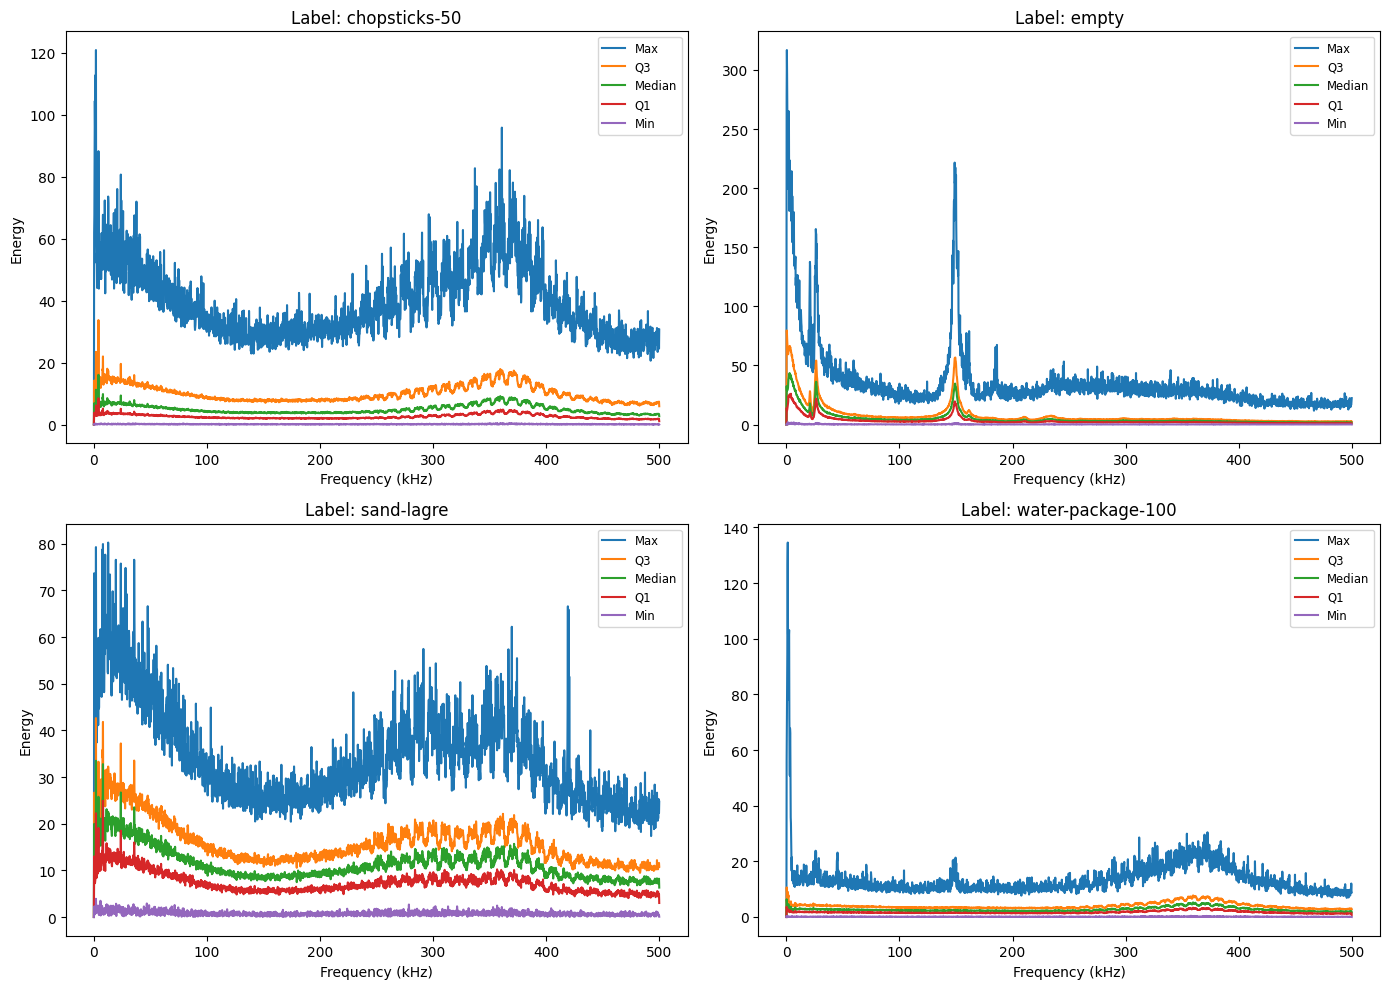

In [38]:
plot_spectrum_default(label_list, freq_list, spec_list, enabled_db, enabled_functions)

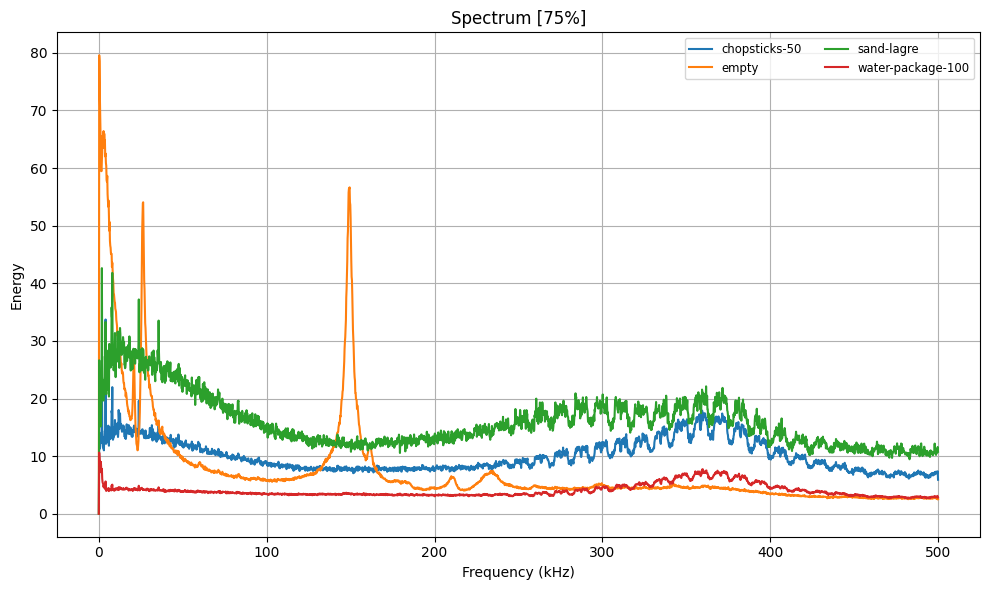

In [43]:
plot_spectrum(
    presentage=75,
    label_list=label_list,
    freq_list=freq_list,
    
    spec_list=spec_list,
    # spec_list=spec_list / np.max(np.abs(spec_list), axis=1, keepdims=True),
    
    enabled_db=enabled_db,
    enabled_functions=enabled_functions,
    # figsize=np.array([10, 6]) * 2,
)